# Find population of a US CITY based on
    
    ALAND
    AWATER
    LAT
    LONG
    STATE
    UAtype

https://www.census.gov/geo/maps-data/data/gazetteer2010.html

steps to train a DNN
1. Prepare data
_ clean data
_ vectorize/encode data
_ split data in train,validation and test data
2. Train model
_ create model and layers
_ compile mode(optimizer , metrics, loss)
_ fit model(train data, validation data, epochs, mini batch size)
3. Validate model
_ validate on test data
4. Repeat


Changes here 
1. Reduce one-hot size for 'STATES' feature. Put cities within multiple states in the existing encoding of 52 states.
2. Introduce regularization.
3. introduce dropoouts.

In [1]:
import pandas as pd
import numpy as np


In [2]:
#prepare data
city_data = []
#00037	Abbeville, LA Urban Cluster	C	19824	8460	29222871	300497	      11.283	       0.116	 29.967602	 -92.098219  
def parseline(line):
    parts = line.split('\t')
    data={}
    namepart = parts[1].split(',')
    data['NAME']=namepart[0]
    data['STATE']=namepart[1].strip().split()[0].strip()
    data['UAtype']=parts[2]
    data['POP10']= int(parts[3])
    data['ALAND']= int(parts[5])
    data['AWATER']= int(parts[6])
    data['LAT']=float(parts[9])
    data['LONG']=float(parts[10])
    return data
with open('Gaz_ua_national.txt','r') as file:
    city_data = [ parseline(line.strip()) for line in file.readlines()[1:]]

In [3]:
city_data[-1]

{'NAME': 'Zuni Pueblo',
 'STATE': 'NM',
 'UAtype': 'C',
 'POP10': 6744,
 'ALAND': 11876813,
 'AWATER': 0,
 'LAT': 35.071062,
 'LONG': -108.823725}

In [4]:
len(city_data)

3592

In [5]:
df = pd.DataFrame(city_data)
df = df.sample(len(df))#shuffle
df.head()

,ALAND,AWATER,LAT,LONG,NAME,POP10,STATE,UAtype
2004,5530474,0,34.772300,-90.764965,Marianna,3804,AR,C
485,50254231,31525,38.438739,-105.212346,Cañon City,27139,CO,C
925,3574241,0,42.664604,-93.903820,Eagle Grove,3076,IA,C
1653,45701795,44214,32.399457,-94.875627,Kilgore,15957,TX,C
521,18006912,0,32.157973,-94.342948,Carthage,6492,TX,C


In [37]:
def to_numerical(labels):
    numerical_dict={}
    for label in labels:
        if label not in numerical_dict:
            numerical_dict[label]=len(numerical_dict)
    return numerical_dict

def to_one_hot(labels):
    numerical = to_numerical(labels)
    one_hot = np.zeros((len(labels),len(numerical)))
    for i,label in enumerate(labels):
        one_hot[i,numerical[label]]=1
    return np.asarray(one_hot)
def to_one_hot_states(labels):
    unique_states = set()
    for label in labels:
        unique_states.update([state for state in label.split('--')])
    numerical = to_numerical(unique_states)
    one_hot = np.zeros((len(labels),len(numerical)))
    for i,label in enumerate(labels):
        for state in label.split('--'):
            one_hot[i,numerical[state]]=1
    return np.asarray(one_hot)

In [38]:
#normalise data
train, validation, test = (0.6,0.2,0.2)
numeric_data = np.asarray(df[['ALAND','AWATER','LAT','LONG']].values)
print(numeric_data[0])
mean=[]
std=[]
def normalize_data(numeric_data,fraction):
    global mean, std
    train_size = int(len(numeric_data)*fraction)
    mean =  numeric_data[:train_size].mean(axis=0)
    std =  numeric_data[:train_size].std(axis=0)
    return (numeric_data - mean)/std
 
numeric_data = normalize_data(numeric_data,train)


[ 5.5304740e+06  0.0000000e+00  3.4772300e+01 -9.0764965e+01]


In [45]:
#df.groupby('STATE')['STATE'].count()
to_one_hot_states(df['STATE'].values).shape

(3592, 52)

In [46]:
#encode data
states = to_one_hot_states(df['STATE'].values)
UA = to_one_hot(df['UAtype'].values)
numeric_data = np.concatenate((numeric_data,states,UA),axis=1)
#merge all data
population = np.asarray(df['POP10'].values).astype(np.float32)/1000#population in thousands
population = population.reshape(len(population),1)
population.min()

2.5

In [47]:
numeric_data.shape

(3592, 58)

In [48]:
#split data
train_f, validation_f, test_f = (0.7,0.2,0.1)
train = int(train_f*len(numeric_data))
validation = int((train_f+validation_f)*len(numeric_data))
print(validation)
x_train,x_validate,x_test = (numeric_data[:train],numeric_data[train:(validation)],numeric_data[validation:])
y_train,y_validate,y_test = (population[:train],population[train:(validation)],population[validation:])

3232


In [49]:
x_train.shape,x_validate.shape,x_test.shape

((2514, 58), (718, 58), (360, 58))

In [89]:
from keras import Sequential
from keras import layers
from keras import models
from keras import losses
from keras import optimizers
from keras import metrics
from keras import regularizers

def createmodel(nodes):
    model = Sequential()
    model.add(layers.Dense(nodes[0],activation='relu',input_shape=(x_train.shape[1],)))
    for layer in range(len(nodes)-1):
        model.add(layers.Dense(nodes[layer+1],activation='relu'))
    model.add(layers.Dense(1))#relu activation to avoid negetives produces bad results here
    
    model.compile(optimizer='rmsprop',loss=['mape'],metrics=['mae'])
    return model

def createmodel(nodes, reg):
    model = Sequential()
    model.add(layers.Dense(nodes[0], kernel_regularizer=regularizers.l2(reg)
                           ,activation='relu',input_shape=(x_train.shape[1],)))
    for layer in range(len(nodes)-1):
        model.add(layers.Dense(nodes[layer+1],kernel_regularizer=regularizers.l2(reg), activation='relu'))
    model.add(layers.Dense(1))#relu activation to avoid negetives produces bad results here
    model.compile(optimizer=optimizers.rmsprop(lr=0.001),loss=['mape'],metrics=['mae'])
    return model

In [93]:
import matplotlib.pyplot as pp
%matplotlib inline
def plothistory(history):
    pp.figure(figsize=(14,4))
    pp.subplot(1,2,1)
    pp.plot(history.history['loss'][10:],label='Training loss')
    pp.plot(history.history['val_loss'][10:],label='Validation loss')
    pp.xlabel('epochs')
    pp.ylabel('loss')
    pp.legend()
    pp.title('Loss vs epoch')
    
    pp.subplot(1,2,2)
    pp.plot(history.history['mean_absolute_error'][10:],label='mean absolute error')
    pp.plot(history.history['val_mean_absolute_error'][10:],label='validation mean absolute error')
    pp.xlabel('epochs')
    pp.ylabel('mae')
    pp.legend()
    pp.title('Mean absolute error vs epoch')
    pp.show()

Regularization =  0.001
Training loss  22.600360480394265
Validation loss  26.971903182005814


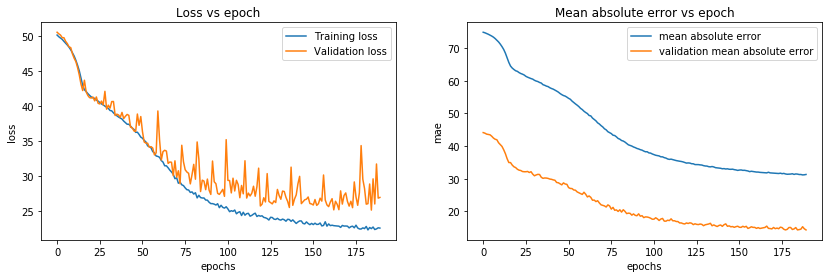

Regularization =  0.01
Training loss  24.219914150313905
Validation loss  26.378344368469747


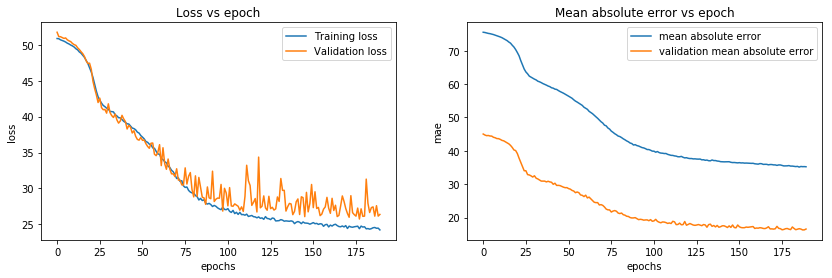

Regularization =  0.1
Training loss  28.79919845714584
Validation loss  28.468022731685373


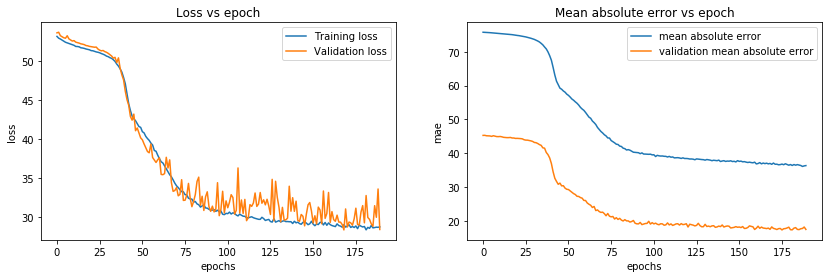

In [102]:
for reg in np.power(10, np.arange(0,3))/1000:
    print ('Regularization = ',reg)
    global model
    model = createmodel([32,16,16],reg)
    history = model.fit(x_train,y_train,
         validation_data=(x_validate,y_validate),
         epochs=200,verbose=0,
         batch_size = 64)
    print ('Training loss ',history.history['loss'][-1])
    print ('Validation loss ',history.history['val_loss'][-1])
    plothistory(history)

Training loss  24.508280067474196
Validation loss  [28.039858395674766, 25.678536077727845, 27.265975272090987, 26.310076588707712, 26.260024200906994]


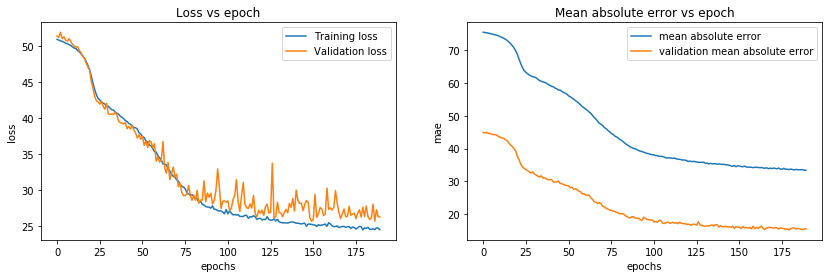

In [132]:
model_final = createmodel([32,16,16],0.01)
history = model_final.fit(x_train,y_train,
     validation_data=(x_validate,y_validate),
     epochs=200,verbose=0,
     batch_size = 64)
print ('Training loss ',history.history['loss'][-1])
print ('Validation loss ',history.history['val_loss'][-5:])
plothistory(history)


In [147]:
def seepredictions(model):
    df_validation = df.loc[df.index[range(train,validation)]].copy()
    #df.tail(len(df)-train).head(validation) #this should work too
    pred = model.predict(x_validate)*1000
    df_validation['Predictions']=pred
    df_validation['ErrorPercentage']=abs(df_validation['Predictions']-df_validation['POP10'])/df_validation['POP10']*100
    return df_validation

In [148]:
print('mean percentage diff = ', seepredictions(model_final)['ErrorPercentage'].mean())
val_df = seepredictions(model_final)
val_df.head()

mean percentage diff =  24.894309076311174


,ALAND,AWATER,LAT,LONG,NAME,POP10,STATE,UAtype,Predictions,ErrorPercentage
1128,13799317,0,40.088084,-104.794737,Fort Lupton,9055,CO,C,8335.037109,7.950998
2448,32999457,219987,44.090331,-93.222543,Owatonna,25394,MN,C,16838.816406,33.689783
788,6064703,84886,36.973704,-82.982809,Cumberland,3711,KY,C,3243.058350,12.609584
1236,18879721,164102,26.221053,-81.563994,Golden Gate Estates,3953,FL,C,5847.809570,47.933457
378,4073282,20810,44.175097,-88.066117,Brillion,2968,WI,C,2589.848389,12.740957


In [149]:
model_final.evaluate(x_test,y_test)

360/360 [==============================] - 0s 87us/step


[30.28242276509603, 15.11720453898112]

In [153]:
val = model_final.predict(x_validate)
np.mean(np.abs(val - y_validate)/y_validate)

#looks like keras history output is different than actual MAPE

0.2489431